# Adaptive Moment Estimation (Adam) for Deep Long Short Term Networks

## Import Dependencies

In [172]:
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import pandas as pd
import pickle
import plotly.graph_objects as go
import yaml

import json

## General Setup

In [63]:
with open('config.yaml', 'rb') as file:
    config = yaml.safe_load(file)

In [64]:
config['DATA']

{'BCC': 'IDR',
 'END_DATE': datetime.date(2022, 10, 20),
 'MAX_TEST': None,
 'MAX_TRAIN': None,
 'MIN_TEST': None,
 'MIN_TRAIN': None,
 'SCC': 'USD',
 'START_DATE': datetime.date(2014, 10, 20),
 'TESTING': 0.2,
 'TRAINING': 0.8}

## Data Collection

- Crawling historical data dari https://ofx.com
- Visualisasi data yang telah didapatkan

In [65]:
# collect data
from utils.data_generator import ofx_dataset
from datetime import datetime
from time import time

In [66]:
start_date= config["DATA"]["START_DATE"]
end_date = config["DATA"]["END_DATE"]

In [67]:
start_date = int( datetime.combine(start_date, datetime.min.time()).timestamp() ) * 1000
end_date   = int( datetime.combine(end_date, datetime.min.time()).timestamp() ) * 1000

In [68]:
datasets = ofx_dataset(start_date, end_date)

200


In [69]:
datasets['timestamps'] = pd.to_datetime(datasets['timestamps'], unit='s')
datasets.set_index('timestamps', inplace=True)
datasets.head()

,values
timestamps,
2014-10-20,12112.0
2014-10-21,11973.0
2014-10-22,11985.0
2014-10-23,12018.0
2014-10-24,12058.0


### Function visualisasi data

In [70]:
def linechart(data: pd.DataFrame):
    plt.plot(data.index, datasets.values)
    plt.xlabel("Histories")
    plt.ylabel("Values")
    plt.title("Historical Data")
    plt.show()

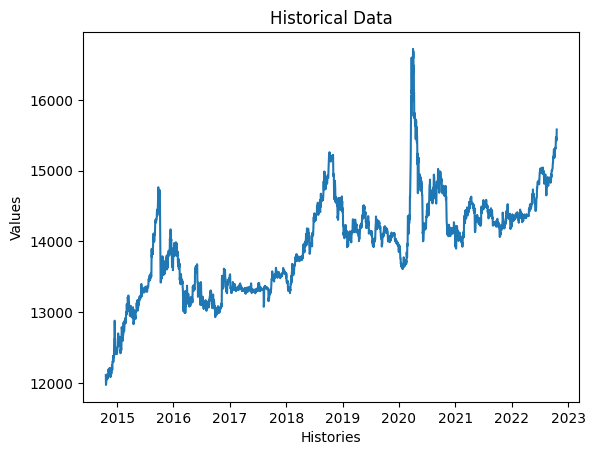

In [71]:
linechart(datasets)

## Data Spliting
- Split data yang telah didapatkan, menjadi 80% training dan 20% testing
- Visualisasi data yang telah dibagi

In [72]:
# proses split data
train_size = round(len(datasets) * .8)
train_df = datasets[:train_size]
test_df = datasets[train_size:]

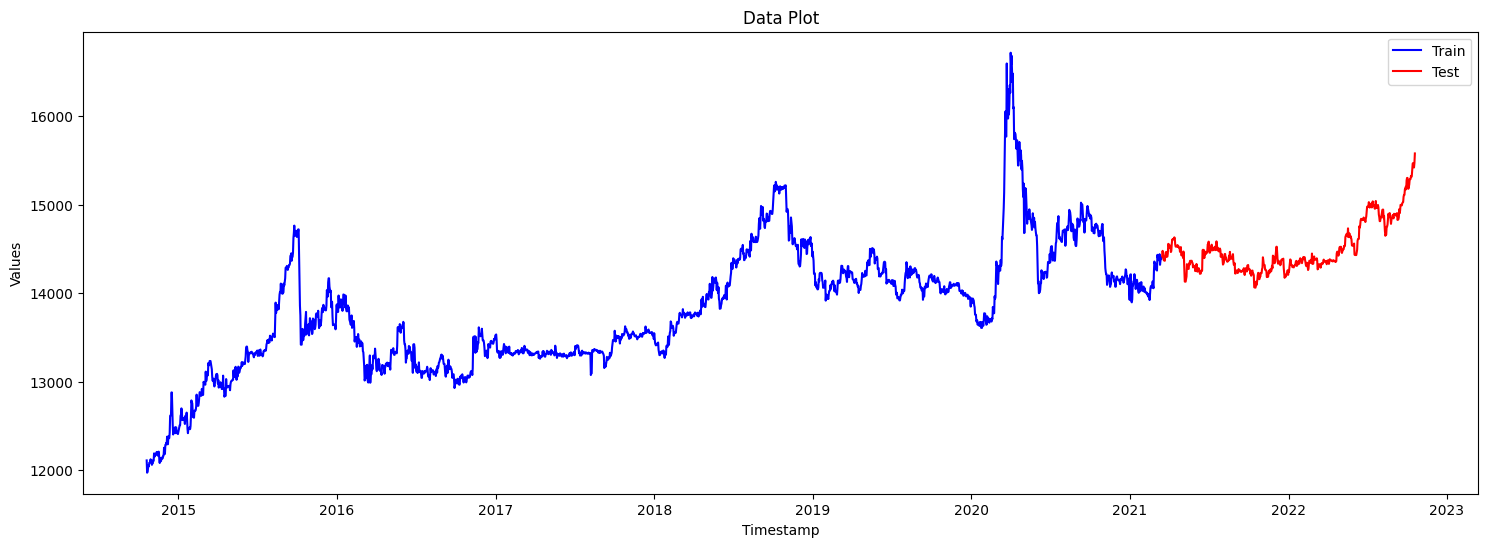

In [73]:
# proses visualisasi data
plt.figure(figsize=(18, 6))
plt.plot(train_df.index, train_df['values'], color='blue', label='Train')
plt.plot(test_df.index, test_df['values'], color='red', label='Test')

# Menambahkan label dan judul plot
plt.xlabel('Timestamp')
plt.ylabel('Values')
plt.title('Data Plot')
plt.legend()

# Menampilkan plot
plt.show()

## Normalisasi Data
- Normalisasi data ke dalam scala -1 .. 1
- Data overview

In [218]:
import numpy as np

class MinMaxScaler:

    def __init__(self, min_val=-1,  max_val=1):
        self.min_val = min_val
        self.max_val = max_val
        self.min_data = None
        self.max_data = None

    def fit(self, data, label='train'):
        self.min_data = min(data)
        self.max_data = max(data)
        config['DATA'][f'MIN_{label.upper()}'] = self.min_data
        config['DATA'][f'MAX_{label.upper()}'] = self.max_data
        with open('config.yaml', 'w') as file:
            yaml.dump(config, file)

    def transform(self, data):
        scaled_data = (data - self.min_data) / (self.max_data - self.min_data)
        scaled_data = scaled_data * (self.max_val - self.min_val) + self.min_val
        return scaled_data

    def inverse_transform(self, scaled_data, min_data=None, max_data=None):
        if min_data:
            self.min_data = min_data
        if max_data:
            self.max_data = max_data

        data = ( scaled_data - self.min_val ) / ( self.max_val - self.min_val )
        data = data * ( self.max_data - self.min_data ) + self.min_data
        return data

In [80]:
# scaling datasets
train_scaler = MinMaxScaler(min_val=-1, max_val=1)
test_scaler = MinMaxScaler(min_val=-1, max_val=1)

train_scaler.fit(train_df['values'])
test_scaler.fit(test_df['values'], label='test')

train_df['normalized_values'] = train_scaler.transform(train_df['values'])
test_df['normalized_values'] = test_scaler.transform(test_df['values'])

/var/folders/zz/htmnld_148b1dbm4wj_hyrq80000gn/T/ipykernel_68787/851816330.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['normalized_values'] = train_scaler.transform(train_df['values'])
/var/folders/zz/htmnld_148b1dbm4wj_hyrq80000gn/T/ipykernel_68787/851816330.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['normalized_values'] = test_scaler.transform(test_df['values'])


## Sliding Window

In [161]:
def sliding_window(data, window_size):
    X = []
    y = []
    for i in range(len(data) - window_size):
        X.append(data[ i : i+window_size ])
        y.append(data[ i + window_size ])
    X = np.array(X)
    y = np.array(y)
    X_reshape = X.reshape(X.shape[0], X.shape[1], 1)
    y_reshape = y.reshape(y.shape[0], 1)
    return torch.from_numpy(X_reshape).type(torch.Tensor), torch.from_numpy(y_reshape).type(torch.Tensor)

In [162]:
for i in config["MODEL"]["INPUT_SIZE"]:
    vars()[f'X_train_{i}'], vars()[f'y_train_{i}'] = sliding_window(data=train_df.normalized_values, window_size=i)
    vars()[f'X_test_{i}'], vars()[f'y_test_{i}'] = sliding_window(data=test_df.normalized_values, window_size=i)

# Modeling

## Generic LSTM

In [163]:
class LSTMModel(nn.Module):

    def __init__(self, input_size, hidden_sizes, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_sizes = hidden_sizes
        self.num_layers = len(hidden_sizes)
        self.lstms = nn.ModuleList()
        self.lstms.append(
            nn.LSTM(input_size, hidden_sizes[0])
        )

        for i in range(1, self.num_layers):
            self.lstms.append(
                nn.LSTM(hidden_sizes[i-1], hidden_sizes[i])
            )

        self.fc = nn.Linear(hidden_sizes[-1], output_size)
        self.init_weights()

    def init_weights(self):
        for i in range(self.num_layers):
            for name, param in self.lstms[i].named_parameters():
                if 'weight' in name:
                    if param.data.dim() > 1:
                        nn.init.xavier_normal_(param)
                    else:
                        nn.init.zeros_(param)
                elif 'bias' in name:
                    nn.init.constant_(param, 0)

    def forward(self, input):
        for i in range(self.num_layers):
            output, _ = self.lstms[i](input)
            input = output

        output = self.fc(output[:, -1, :])
        return output

## Uji Learning

In [317]:
# class UJI

class Evaluation:
    
    def __init__(self, prediction=[], actual=[]):
        self.prediction = prediction
        self.actual = actual

    def rmse(self):
        return np.sqrt(((self.prediction - self.actual) ** 2).mean())

    def mape(self):
        n_data = len(self.prediction)
        absolute_error = []
        percentage_error = []

        for i in range(n_data):
            absolute_error.append( abs(self.actual[i] - self.prediction[i]) )
            percentage_error.append( absolute_error[i] / abs(self.actual[i]) )
        mape = (sum(percentage_error) / len(self.actual)) * 100
        return mape

    def da(self):
        correct_directions = 0
        total_predictions = len(self.actual)

        for i in range(total_predictions):
            if (self.actual[i] > 0 and self.prediction[i] > 0) or (self.actual[i] < 0 and self.prediction[i] < 0):
                correct_directions += 1

        directional_accuracy = correct_directions / total_predictions * 100
        return directional_accuracy


In [164]:
config

{'DATA': {'BCC': 'IDR',
  'END_DATE': datetime.date(2022, 10, 20),
  'MAX_TEST': 15580.5,
  'MAX_TRAIN': 16718.5,
  'MIN_TEST': 14064.45,
  'MIN_TRAIN': 11973.0,
  'SCC': 'USD',
  'START_DATE': datetime.date(2014, 10, 20),
  'TESTING': 0.2,
  'TRAINING': 0.8},
 'MODEL': {'CHECKPOINT': '',
  'DROPOUT': None,
  'EPOCHS': 100,
  'HIDDEN_LAYER': 2,
  'HIDDEN_SIZE': [8, 16, 32, 64],
  'INPUT_SIZE': [7, 8, 9, 10],
  'LEARNING_RATE': [0.1, 0.01, 0.001],
  'MODEL_NAME': '',
  'OPTIM_FUNC': 'Adam',
  'OUTPUT_SIZE': 1},
 'TICKERS': ['USDIDR', 'JPYIDR'],
 'WEIGHT': {'SAVE_BEST': True, 'SAVE_WEIGHT_PATH': './models'}}

In [184]:
for lr in config['MODEL']['LEARNING_RATE']:
    model = LSTMModel(
        input_size=1,
        hidden_sizes=[1],
        output_size=1
    )
    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    loss_histories = []
    num_epochs = 1000
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train_7)
        loss = criterion(output, y_train_7)
        loss.backward()
        optimizer.step()

        loss_histories.append(loss.item())

        if (epoch + 1) % 10 == 0:
            print(f"Epoch: {epoch+1}/{num_epochs}, Loss: {loss.item()}")

    with open(f"models/{config['DATA']['SCC']}/loss_histories_{lr}.pkl", 'wb') as f:
        pickle.dump(loss_histories, f)
    torch.save(model.state_dict(), f"models/{config['DATA']['SCC']}/lr_{lr}.pth")

Epoch: 10/1000, Loss: 0.08693698793649673
Epoch: 20/1000, Loss: 0.0854739099740982
Epoch: 30/1000, Loss: 0.0802074447274208
Epoch: 40/1000, Loss: 0.07624313980340958
Epoch: 50/1000, Loss: 0.06643510609865189
Epoch: 60/1000, Loss: 0.04523857682943344
Epoch: 70/1000, Loss: 0.011795423924922943
Epoch: 80/1000, Loss: 0.00653056101873517
Epoch: 90/1000, Loss: 0.0035928941797465086
Epoch: 100/1000, Loss: 0.003504922380670905
Epoch: 110/1000, Loss: 0.002869039075449109
Epoch: 120/1000, Loss: 0.0027037248946726322
Epoch: 130/1000, Loss: 0.0025105627719312906
Epoch: 140/1000, Loss: 0.0023901218082755804
Epoch: 150/1000, Loss: 0.00227530300617218
Epoch: 160/1000, Loss: 0.002179032424464822
Epoch: 170/1000, Loss: 0.002092215232551098
Epoch: 180/1000, Loss: 0.00201516505330801
Epoch: 190/1000, Loss: 0.001945615280419588
Epoch: 200/1000, Loss: 0.001882788841612637
Epoch: 210/1000, Loss: 0.001825753366574645
Epoch: 220/1000, Loss: 0.00177381734829396
Epoch: 230/1000, Loss: 0.001726345857605338
Epoch

In [186]:
# import plotly.graph_objects as go

fig = go.Figure()
x = [x+1 for x in range(1000)]
# for lr in params["LR"]:
for lr in config['MODEL']["LEARNING_RATE"]:
    with open(f"models/{config['DATA']['SCC']}/loss_histories_{lr}.pkl", 'rb') as f:
        loss_histories = pickle.load(f)
    
        fig.add_trace(go.Scatter(x=x, y=loss_histories, mode='lines', name=f"loss histories of {lr}"))
        
        fig.update_layout(
            xaxis_title='epoch',
            yaxis_title='loss',
            title=f"Loss error {config['MODEL']['LEARNING_RATE']}",
            height=800
        )
fig.show()

## Uji Jumlah Feature Input dan Hidden Layer 1

In [188]:
config

{'DATA': {'BCC': 'IDR',
  'END_DATE': datetime.date(2022, 10, 20),
  'MAX_TEST': 15580.5,
  'MAX_TRAIN': 16718.5,
  'MIN_TEST': 14064.45,
  'MIN_TRAIN': 11973.0,
  'SCC': 'USD',
  'START_DATE': datetime.date(2014, 10, 20),
  'TESTING': 0.2,
  'TRAINING': 0.8},
 'MODEL': {'CHECKPOINT': '',
  'DROPOUT': None,
  'EPOCHS': 100,
  'HIDDEN_LAYER': 2,
  'HIDDEN_SIZE': [8, 16, 32, 64],
  'INPUT_SIZE': [7, 8, 9, 10],
  'LEARNING_RATE': [0.1, 0.01, 0.001],
  'MODEL_NAME': '',
  'OPTIM_FUNC': 'Adam',
  'OUTPUT_SIZE': 1},
 'TICKERS': ['USDIDR', 'JPYIDR'],
 'WEIGHT': {'SAVE_BEST': True, 'SAVE_WEIGHT_PATH': './models'}}

In [189]:
for window in config['MODEL']['INPUT_SIZE']:

    for hidden_size in config['MODEL']['HIDDEN_SIZE']:
        model = LSTMModel(
            input_size=1,
            hidden_sizes=[hidden_size],
            output_size=config['MODEL']['OUTPUT_SIZE']
        )
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=.001)

        loss_histories = []
        num_epochs = config['MODEL']['EPOCHS']
        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()
            output = model(vars()[f"X_train_{window}"])
            loss = criterion(output, vars()[f"y_train_{window}"])
            loss.backward()
            optimizer.step()

            loss_histories.append(loss.item())

            if (epoch + 1) % 10 == 0:
                print(f"Epoch: {epoch + 1}/{num_epochs}, Loss: {loss.item()}")

        with open(f"models/{config['DATA']['SCC']}/hist_{window}_{hidden_size}.pkl", 'wb') as file:
            pickle.dump(loss_histories, file)
        torch.save(model.state_dict(), f"models/{config['DATA']['SCC']}/{window}_{hidden_size}.pth")

Epoch: 10/100, Loss: 0.08603190630674362
Epoch: 20/100, Loss: 0.08028928935527802
Epoch: 30/100, Loss: 0.07597016543149948
Epoch: 40/100, Loss: 0.07185336947441101
Epoch: 50/100, Loss: 0.06720886379480362
Epoch: 60/100, Loss: 0.06180475279688835
Epoch: 70/100, Loss: 0.05519213154911995
Epoch: 80/100, Loss: 0.04666028544306755
Epoch: 90/100, Loss: 0.03534915670752525
Epoch: 100/100, Loss: 0.021783092990517616
Epoch: 10/100, Loss: 0.17014655470848083
Epoch: 20/100, Loss: 0.147798091173172
Epoch: 30/100, Loss: 0.12467587739229202
Epoch: 40/100, Loss: 0.09795650839805603
Epoch: 50/100, Loss: 0.06536629050970078
Epoch: 60/100, Loss: 0.039229124784469604
Epoch: 70/100, Loss: 0.03147105127573013
Epoch: 80/100, Loss: 0.02275109849870205
Epoch: 90/100, Loss: 0.016784008592367172
Epoch: 100/100, Loss: 0.01436404138803482
Epoch: 10/100, Loss: 0.08998967707157135
Epoch: 20/100, Loss: 0.06562041491270065
Epoch: 30/100, Loss: 0.043256983160972595
Epoch: 40/100, Loss: 0.032150015234947205
Epoch: 50/1

### Evaluasi Hasil Input dan Hidden Layer ke 1
<ul>
    <li>Dilakukan dengan cara perulangan kombinasi dari jumlah input dan jumlah hidden pertama. </li>
    <li>kemudian dilakukan evaluasi dengan matriks RMSE, MAPE dan DA </li>
</ul>

In [193]:
config

{'DATA': {'BCC': 'IDR',
  'END_DATE': datetime.date(2022, 10, 20),
  'MAX_TEST': 15580.5,
  'MAX_TRAIN': 16718.5,
  'MIN_TEST': 14064.45,
  'MIN_TRAIN': 11973.0,
  'SCC': 'USD',
  'START_DATE': datetime.date(2014, 10, 20),
  'TESTING': 0.2,
  'TRAINING': 0.8},
 'MODEL': {'CHECKPOINT': '',
  'DROPOUT': None,
  'EPOCHS': 100,
  'HIDDEN_LAYER': 2,
  'HIDDEN_SIZE': [8, 16, 32, 64],
  'INPUT_SIZE': [7, 8, 9, 10],
  'LEARNING_RATE': [0.1, 0.01, 0.001],
  'MODEL_NAME': '',
  'OPTIM_FUNC': 'Adam',
  'OUTPUT_SIZE': 1},
 'TICKERS': ['USDIDR', 'JPYIDR'],
 'WEIGHT': {'SAVE_BEST': True, 'SAVE_WEIGHT_PATH': './models'}}

#### Rasio 1 hari

In [195]:
# load semua model dengan identifikasi layer ke 1
buckets = []
for window in config['MODEL']['INPUT_SIZE']:

    for hidden_1 in config['MODEL']['HIDDEN_SIZE']:
        pass

In [196]:
model = LSTMModel(
    input_size=1, hidden_sizes=[8], output_size=1
)

In [197]:
model.load_state_dict(torch.load('models/USD/10_8.pth'))

<All keys matched successfully>

In [212]:
with torch.no_grad():
    output = model.forward(X_test_10)

In [304]:
output_denorm = test_scaler.inverse_transform(output)
y_actual_denorm = test_scaler.inverse_transform(y_test_10)

In [318]:
eval = Evaluation(actual=y_actual_denorm, prediction=output_denorm)

In [321]:
eval.mape().item(), eval.da(), eval.rmse().item()

(0.48326072096824646, 100.0, 111.40497589111328)

In [296]:
fig = go.Figure()

x = [i for i in range(len(y_actual_denorm))]

fig.add_trace(go.Scatter(x=x, y=y_actual_denorm.squeeze(1), mode='lines', name="Actual"))
fig.add_trace(go.Scatter(x=x, y=output_denorm.squeeze(1)[4:], mode='lines', name="Predicted"))

fig.update_layout(
    xaxis_title='timestep',
    yaxis_title='values',
    title=f"Perbandingan hasil prediksi dan nilai asli",
    height=800
)
fig.show()

#### Rasio 1 bulan

## Uji Hidden Layer 2

### Evaluasi Hasil Hidden Layer 2

#### Rasio 1 hari

#### Rasio 1 bulan